In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
from data.dataloader import dataloader
from GANs.generator import Generator
from GANs.discriminator import Discriminator
from GANs.methods import weight_init, training
from torchinfo import summary

In [2]:
print(torch.__version__)
print(torch.cuda.is_available())

2.9.1+cu128
True


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
latent_dim = 100

noise_z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
train_loader, test_loader = dataloader('CIFAR10', batch_size=batch_size)

In [4]:
# from torchinfo import summary

generator = Generator(latent_dim=latent_dim, img_channels=3, bias=False)
discriminator = Discriminator(in_channels=3, bias=False)

# summary(generator, input_size=(batch_size, latent_dim, 1, 1))
# summary(discriminator, input_size=(batch_size, 3, 32, 32))

generator.apply(weight_init), discriminator.apply(weight_init)

(Generator(
   (generator): Sequential(
     (0): GenBlock(
       (conv): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
       (norm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
     )
     (1): GenBlock(
       (conv): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
     )
     (2): GenBlock(
       (conv): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
     )
     (3): GenBlock(
       (conv): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1

In [15]:
summary(generator, input_size=(batch_size, latent_dim, 1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [64, 3, 32, 32]           --
├─Sequential: 1-1                        [64, 3, 32, 32]           --
│    └─GenBlock: 2-1                     [64, 512, 2, 2]           --
│    │    └─ConvTranspose2d: 3-1         [64, 512, 2, 2]           819,200
│    │    └─BatchNorm2d: 3-2             [64, 512, 2, 2]           1,024
│    │    └─ReLU: 3-3                    [64, 512, 2, 2]           --
│    └─GenBlock: 2-2                     [64, 256, 4, 4]           --
│    │    └─ConvTranspose2d: 3-4         [64, 256, 4, 4]           2,097,152
│    │    └─BatchNorm2d: 3-5             [64, 256, 4, 4]           512
│    │    └─ReLU: 3-6                    [64, 256, 4, 4]           --
│    └─GenBlock: 2-3                     [64, 128, 8, 8]           --
│    │    └─ConvTranspose2d: 3-7         [64, 128, 8, 8]           524,288
│    │    └─BatchNorm2d: 3-8             [64, 128, 8, 8]        

In [16]:
summary(discriminator, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [64]                      --
├─Sequential: 1-1                        [64, 1, 1, 1]             --
│    └─Conv2d: 2-1                       [64, 64, 16, 16]          3,072
│    └─LeakyReLU: 2-2                    [64, 64, 16, 16]          --
│    └─DiscBlock: 2-3                    [64, 128, 8, 8]           --
│    │    └─Conv2d: 3-1                  [64, 128, 8, 8]           131,072
│    │    └─InstanceNorm2d: 3-2          [64, 128, 8, 8]           256
│    │    └─LeakyReLU: 3-3               [64, 128, 8, 8]           --
│    └─DiscBlock: 2-4                    [64, 256, 4, 4]           --
│    │    └─Conv2d: 3-4                  [64, 256, 4, 4]           524,288
│    │    └─InstanceNorm2d: 3-5          [64, 256, 4, 4]           512
│    │    └─LeakyReLU: 3-6               [64, 256, 4, 4]           --
│    └─DiscBlock: 2-5                    [64, 512, 2, 2]           --


In [16]:
criterion = nn.BCEWithLogitsLoss()
optimizerG = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=5e-5, betas=(0.5, 0.999))  # if it breaks try 5e-5

d_losses, g_losses = training(
    generator=generator,
    discriminator=discriminator,
    train_loader=train_loader,
    epochs=50,
    optimizerG=optimizerG,
    optimizerD=optimizerD,
    criterion=criterion,
    device=device,
    use_amp=True
)

Training Progress: 100%|██████████| 50/50 [29:00<00:00, 34.81s/it, train_D_loss=0.00714, train_G_loss=0.00574] 


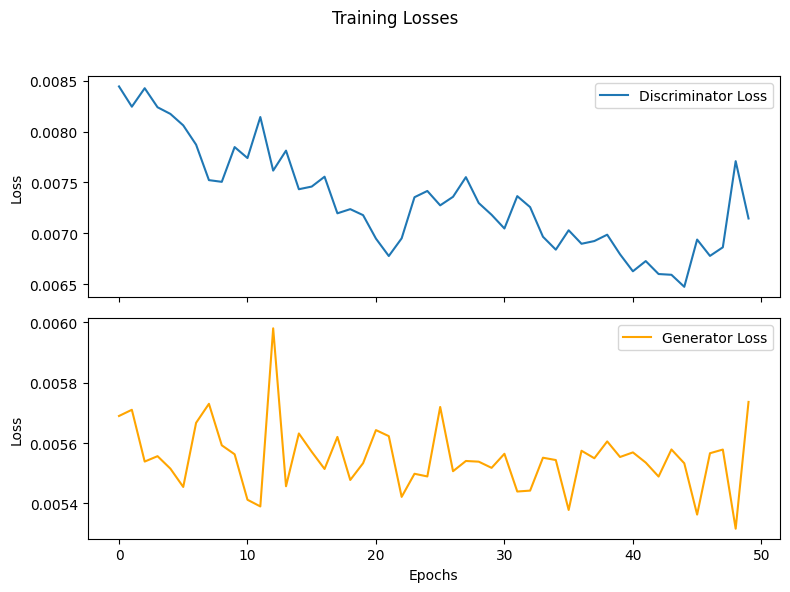

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
fig.suptitle('Training Losses')

axes[0].plot(d_losses, label='Discriminator Loss')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(g_losses, label='Generator Loss', color='orange')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

torch.Size([16, 3, 32, 32])


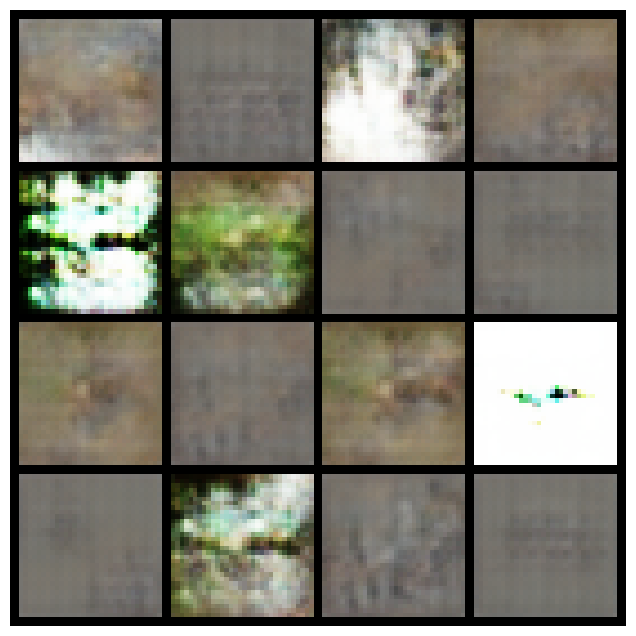

In [ ]:
example = torch.randn(16, latent_dim, 1, 1, device=device)
generator.eval()
with torch.no_grad():
    generator.to(device=device)
    generated_images = generator(example)
    print(generated_images.shape)

grid = torchvision.utils.make_grid(generated_images.cpu(), nrow=4, normalize=True)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()